In [1]:
# Importing necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# DATA COLLECTION AND FEATURE ENGINEERING

In [4]:
# Import necessary libraries for data collection
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker and date range
ticker = 'RELIANCE.NS'
start_date = '2014-01-01'
end_date = '2024-12-31'

# Download the stock data
df = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows and summary statistics of the data
print("Data Overview:")
print(df.head())
print("\nData Description:")
print(df.describe())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data Overview:
Price            Close        High         Low        Open      Volume
Ticker     RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
Date                                                                  
2014-01-01  183.732117  185.685614  183.484047  185.520229     5849398
2014-01-02  180.879379  185.220485  179.866456  183.504708     6023632
2014-01-03  178.657150  180.538297  176.744996  180.176535    12833897
2014-01-06  176.734634  178.450411  175.711376  178.212676    13315857
2014-01-07  174.078354  177.768285  173.654578  176.662341    17311470

Data Description:
Price         Close         High          Low         Open        Volume
Ticker  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS   RELIANCE.NS
count   2710.000000  2710.000000  2710.000000  2710.000000  2.710000e+03
mean     681.671338   689.138533   674.821636   682.172108  1.807056e+07
std      430.266036   434.352022   426.504254   430.574542  1.313834e+07
min      165.365097   166.781131 

In [5]:

# Calculate the daily market return as the percentage change in 'Close'
df['Market_Return'] = df['Close'].pct_change()

# Create rolling averages and standard deviations over 20-day and 50-day windows
window_sizes = [20, 50]
for window in window_sizes:
    df[f'Rolling_Mean_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'Rolling_STD_{window}'] = df['Close'].rolling(window=window).std()

# Generate lagged returns to capture momentum effects
df['Lag1_Return'] = df['Market_Return'].shift(1)
df['Lag2_Return'] = df['Market_Return'].shift(2)

# Create a binary target variable: 1 if next day's close is higher than today, otherwise 0
df['Price_Rise'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# Drop rows with missing values due to the rolling calculations and shifting
df.dropna(inplace=True)

# Display a few rows to check the newly engineered features
print("Engineered Features Overview:")
print(df[['Close', 'Market_Return', 'Rolling_Mean_20', 'Rolling_STD_20', 'Lag1_Return', 'Price_Rise']].head())


Engineered Features Overview:
Price            Close Market_Return Rolling_Mean_20 Rolling_STD_20  \
Ticker     RELIANCE.NS                                                
Date                                                                  
2014-03-12  180.124847     -0.003887      170.360461       5.565875   
2014-03-13  181.819962      0.009411      170.997675       6.113613   
2014-03-14  183.184296      0.007504      171.811632       6.604080   
2014-03-18  185.313507      0.011623      172.580630       7.238820   
2014-03-19  186.667511      0.007307      173.518101       7.795862   

Price      Lag1_Return Price_Rise  
Ticker                             
Date                               
2014-03-12   -0.012084          1  
2014-03-13   -0.003887          1  
2014-03-14    0.009411          1  
2014-03-18    0.007504          1  
2014-03-19    0.011623          1  


# EXPLORATORY DATA ANALYSIS (EDA)

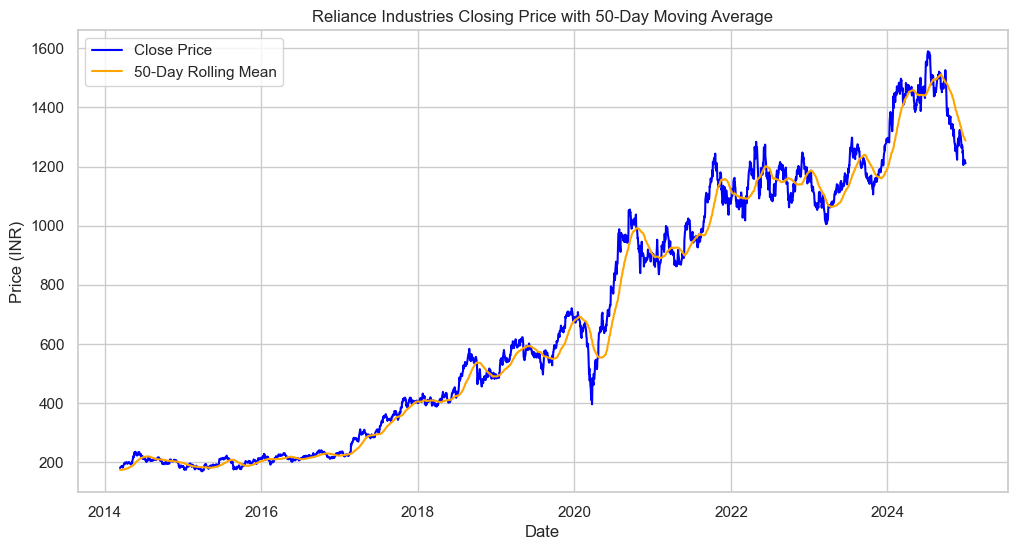

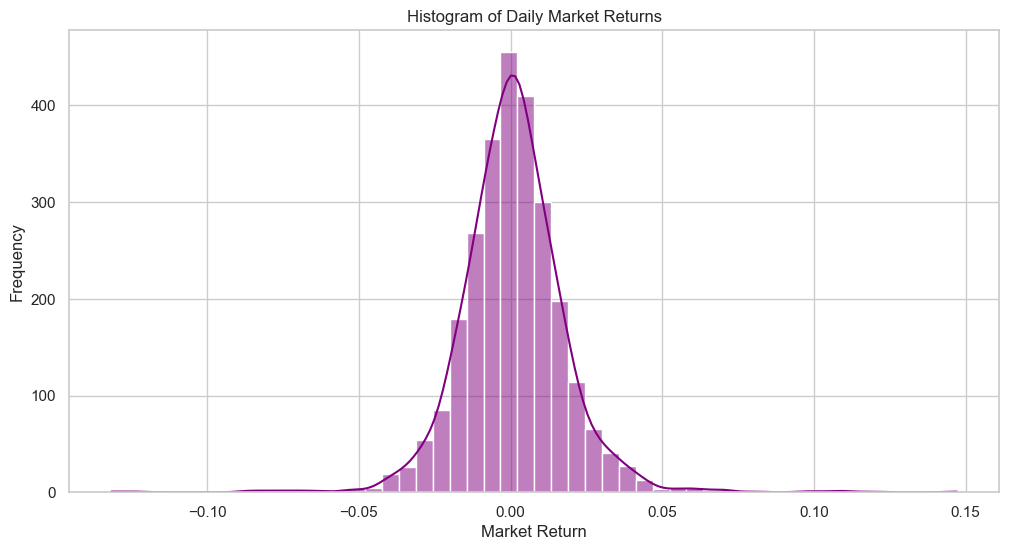

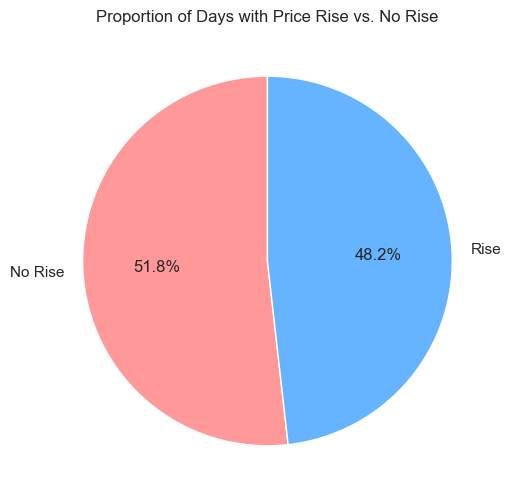

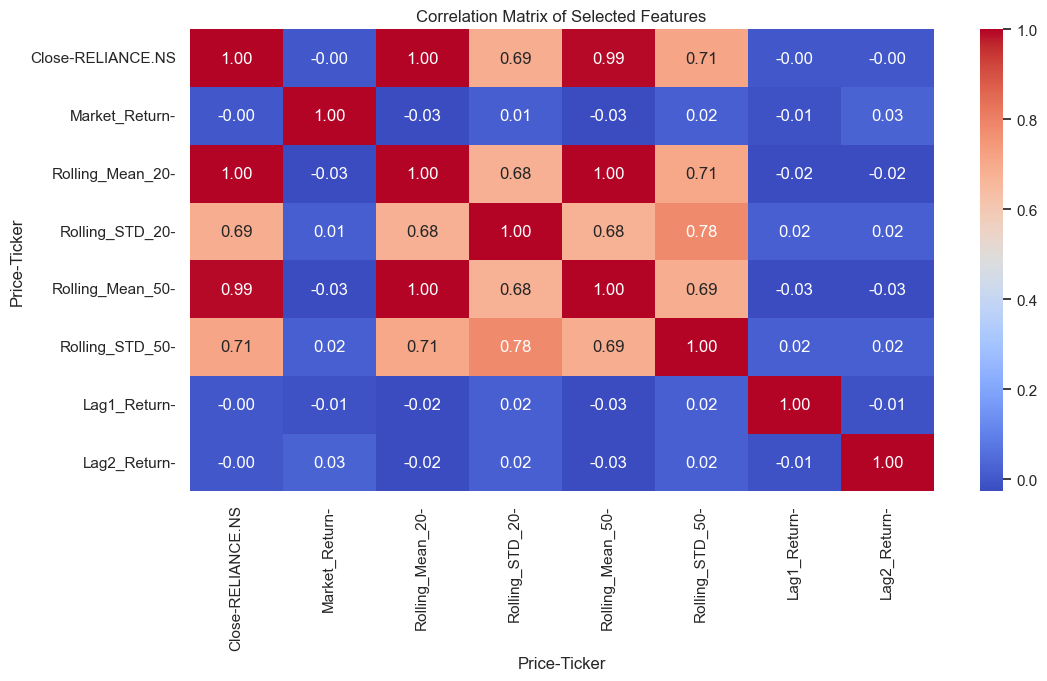

In [9]:


sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# --- A. Line Plot: Closing Price Over Time ---
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['Rolling_Mean_50'], label='50-Day Rolling Mean', color='orange')
plt.title('Reliance Industries Closing Price with 50-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()


# --- B. Histogram: Daily Market Returns ---
plt.figure()
sns.histplot(df['Market_Return'], bins=50, kde=True, color='purple')
plt.title('Histogram of Daily Market Returns')
plt.xlabel('Market Return')
plt.ylabel('Frequency')
plt.show()

# --- C. Pie Chart: Proportion of Price Rise vs. No Rise ---
rise_counts = df['Price_Rise'].value_counts()
plt.figure()
plt.pie(rise_counts, labels=['No Rise', 'Rise'], autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Proportion of Days with Price Rise vs. No Rise')
plt.show()

# --- D. Correlation Heatmap for Selected Features ---
plt.figure()
cols = ['Close', 'Market_Return', 'Rolling_Mean_20', 'Rolling_STD_20', 'Rolling_Mean_50', 'Rolling_STD_50', 'Lag1_Return', 'Lag2_Return']
sns.heatmap(df[cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()


# MACHINE LEARNING MODEL IMPLEMENTATION

In [12]:
#Machine Learning Model Implementation

# Train-Test Split

from sklearn.model_selection import train_test_split

# Define the feature set and target variable
features = ['Market_Return', 'Rolling_Mean_20', 'Rolling_STD_20', 'Rolling_Mean_50', 'Rolling_STD_50', 'Lag1_Return', 'Lag2_Return']
X = df[features]
y = df['Price_Rise']

# Split the data (70% train, 30% test) and maintain the order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (1862, 7)
Testing set shape: (799, 7)


In [14]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Instantiate the Extra Trees Classifier
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)

# 5-fold cross-validation on the training set
etc_cv_scores = cross_val_score(etc, X_train, y_train, cv=5, scoring='accuracy')
print("Extra Trees CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(etc_cv_scores.mean(), etc_cv_scores.std()))

# Fit the model on the training data
etc.fit(X_train, y_train)

# Predict on the test set
etc_pred = etc.predict(X_test)
etc_pred_proba = etc.predict_proba(X_test)[:, 1]

# Accuracy comparison
etc_accuracy = etc.score(X_test, y_test)
print(f"Extra Trees Accuracy: {etc_accuracy:.4f}")

# Print the classification report for ETC
print("\nClassification Report for Extra Trees Classifier:")
print(classification_report(y_test, etc_pred))





Extra Trees CV Accuracy: Mean = 0.4732, Std = 0.0155
Extra Trees Accuracy: 0.5006

Classification Report for Extra Trees Classifier:
              precision    recall  f1-score   support

           0       0.38      0.04      0.07       389
           1       0.51      0.94      0.66       410

    accuracy                           0.50       799
   macro avg       0.44      0.49      0.37       799
weighted avg       0.45      0.50      0.37       799



In [16]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 5-fold cross-validation on the training set for Random Forest
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(rf_cv_scores.mean(), rf_cv_scores.std()))

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the test set
rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)[:, 1]

# Accuracy comparison

rf_accuracy = rf.score(X_test, y_test)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Print the classification report for Random Forest
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, rf_pred))



Random Forest CV Accuracy: Mean = 0.4587, Std = 0.0313
Random Forest Accuracy: 0.5257

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.53      0.27      0.35       389
           1       0.53      0.77      0.63       410

    accuracy                           0.53       799
   macro avg       0.53      0.52      0.49       799
weighted avg       0.53      0.53      0.49       799



# EVALUATION OF CLASSIFIERS' PERFORMANCE AND RESULTS

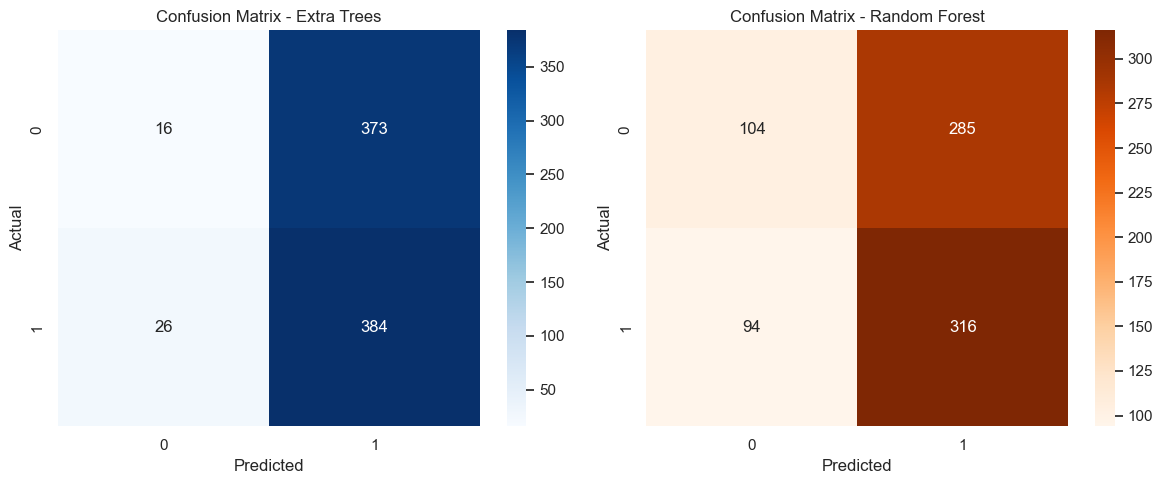

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Extra Trees Confusion Matrix
cm_etc = confusion_matrix(y_test, etc_pred)
sns.heatmap(cm_etc, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Extra Trees')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Confusion Matrix - Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


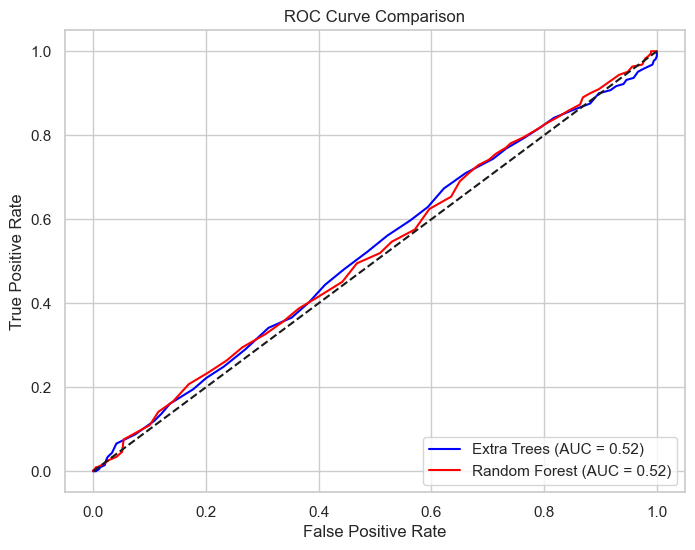

In [20]:
# Compute ROC curves
fpr_etc, tpr_etc, _ = roc_curve(y_test, etc_pred_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)

# Compute AUC
auc_etc = auc(fpr_etc, tpr_etc)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_etc, tpr_etc, label=f'Extra Trees (AUC = {auc_etc:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


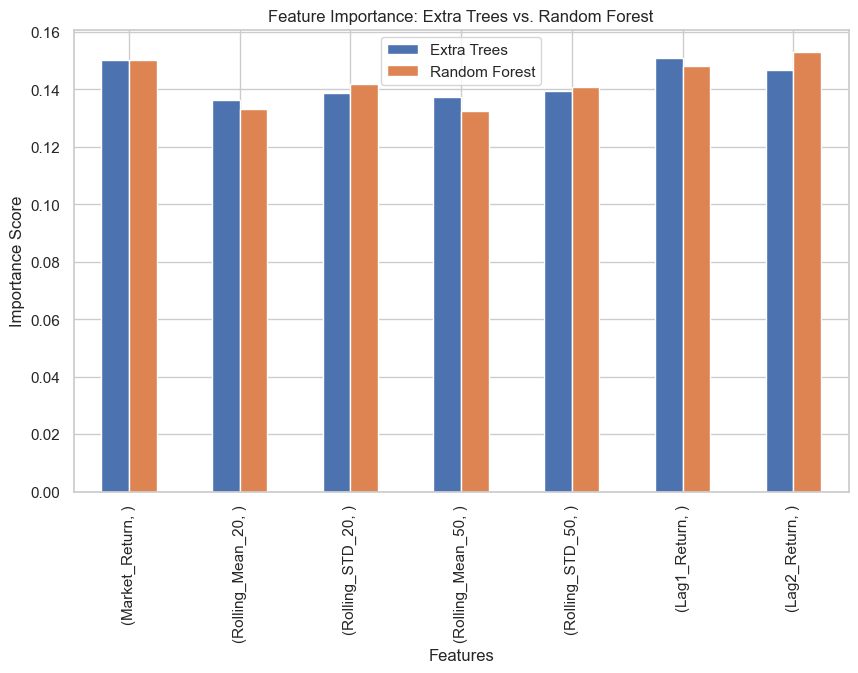

In [23]:
# Feature importance for Extra Trees
etc_feature_importance = etc.feature_importances_
rf_feature_importance = rf.feature_importances_

# Create a DataFrame to store feature importances
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Extra Trees': etc_feature_importance, 'Random Forest': rf_feature_importance})

# Plot feature importance
feature_df.set_index('Feature').plot(kind='bar', figsize=(10,6))
plt.title('Feature Importance: Extra Trees vs. Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


# EVALUATION OF PREDICTED PRICE USING X_TEST DATA: EXTRA TREE 

In [32]:
# Predict on X_test using Extra Trees
y_pred_etc = etc.predict(X_test)

# Create a DataFrame to store actual vs predicted values
df_pred_etc = df.loc[X_test.index].copy()
df_pred_etc['Predicted_Price_Rise_ETC'] = y_pred_etc
df_pred_etc['Actual_Price_Rise'] = y_test

# Display first few rows
df_pred_etc[['Close', 'Predicted_Price_Rise_ETC', 'Actual_Price_Rise']].head()

Price,Close,Predicted_Price_Rise_ETC,Actual_Price_Rise
Ticker,RELIANCE.NS,,
Date,,,
2021-10-05,1187.913574,1,0
2021-10-06,1165.445435,1,1
2021-10-07,1171.159302,1,1
2021-10-08,1216.163574,1,0
2021-10-11,1207.695312,1,1


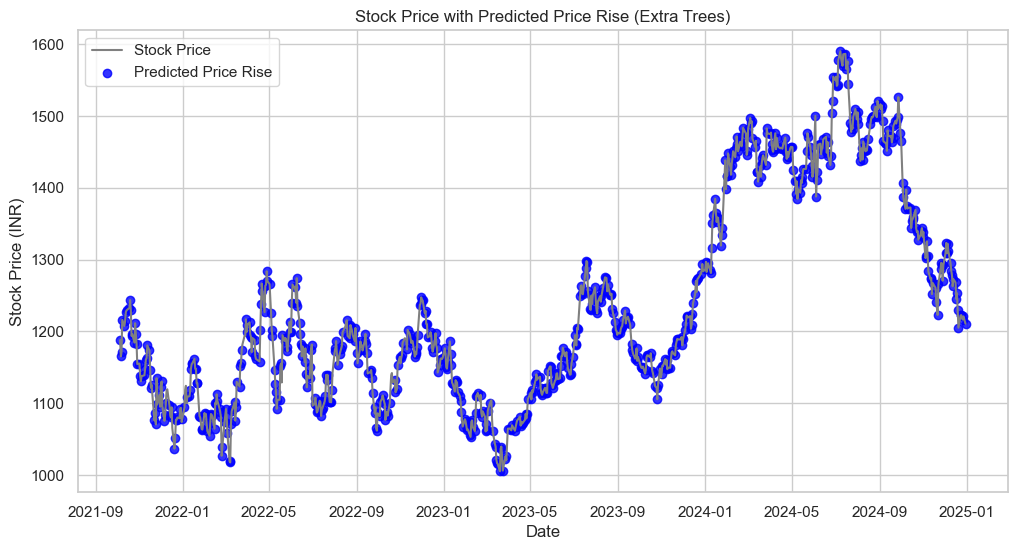

In [34]:
plt.figure(figsize=(12,6))
plt.plot(df_pred_etc.index, df_pred_etc['Close'], label='Stock Price', color='gray')

# Highlight predicted price rise points
plt.scatter(df_pred_etc.index[df_pred_etc['Predicted_Price_Rise_ETC'] == 1],
            df_pred_etc['Close'][df_pred_etc['Predicted_Price_Rise_ETC'] == 1],
            color='blue', label='Predicted Price Rise', marker='o', alpha=0.8)

plt.title("Stock Price with Predicted Price Rise (Extra Trees)")
plt.xlabel("Date")
plt.ylabel("Stock Price (INR)")
plt.legend()
plt.show()

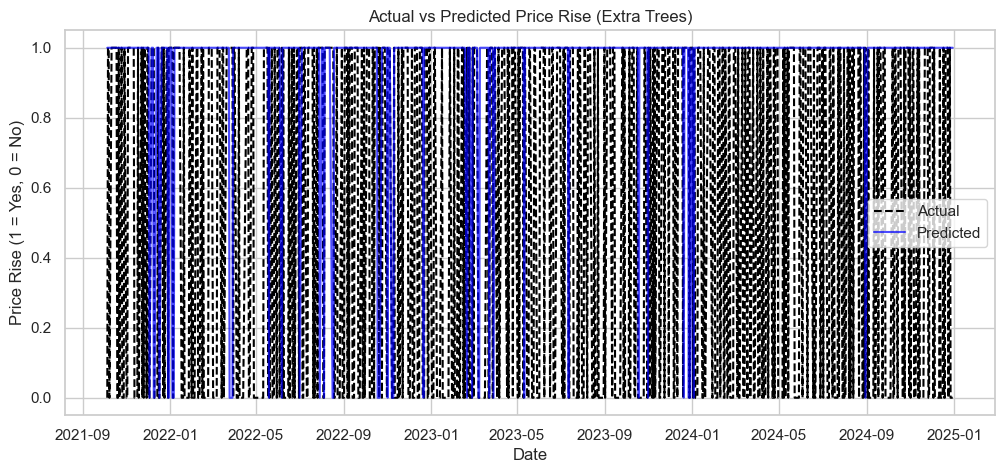

In [36]:
plt.figure(figsize=(12,5))
plt.plot(df_pred_etc.index, df_pred_etc['Actual_Price_Rise'], label="Actual", color='black', linestyle='dashed')
plt.plot(df_pred_etc.index, df_pred_etc['Predicted_Price_Rise_ETC'], label="Predicted", color='blue', alpha=0.7)
plt.title("Actual vs Predicted Price Rise (Extra Trees)")
plt.xlabel("Date")
plt.ylabel("Price Rise (1 = Yes, 0 = No)")
plt.legend()
plt.show()

# TRADING STRATEGY

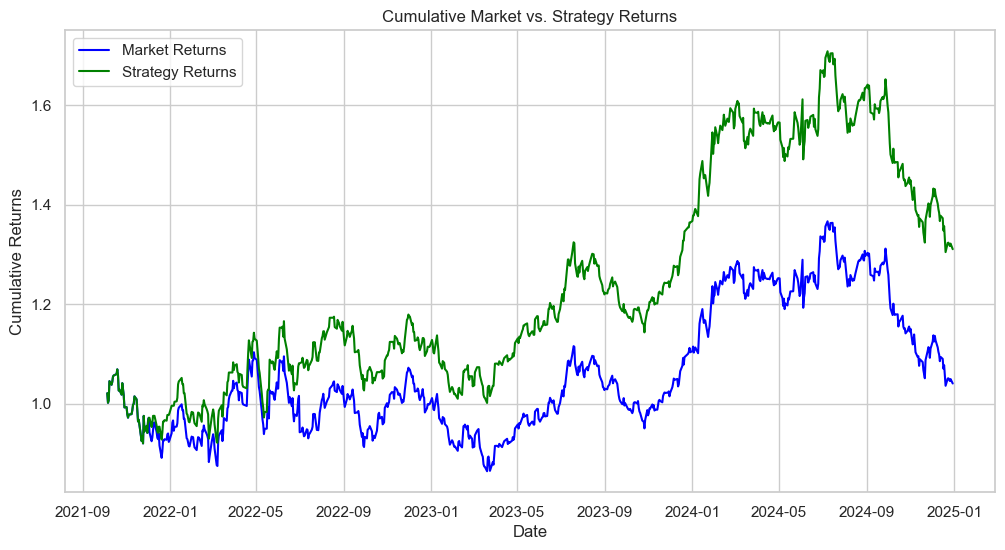

In [76]:
# Ensure df_strategy uses label-based indexing
df_strategy = df.loc[X_test.index].copy()

# Add the ETC predicted signals to the DataFrame
df_strategy['Predicted_Signal'] = etc_pred

# Calculate Strategy Return: if predicted signal is 1, take the day's market return; otherwise, zero return.
df_strategy['Strategy_Return'] = df_strategy['Market_Return'] * df_strategy['Predicted_Signal']

# Calculate cumulative returns for both the market and the strategy
df_strategy['Cumulative_Market_Return'] = (1 + df_strategy['Market_Return']).cumprod()
df_strategy['Cumulative_Strategy_Return'] = (1 + df_strategy['Strategy_Return']).cumprod()

# Plot the cumulative returns
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_strategy.index, df_strategy['Cumulative_Market_Return'], label='Market Returns', color='blue')
plt.plot(df_strategy.index, df_strategy['Cumulative_Strategy_Return'], label='Strategy Returns', color='green')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Market vs. Strategy Returns')
plt.legend()
plt.show()



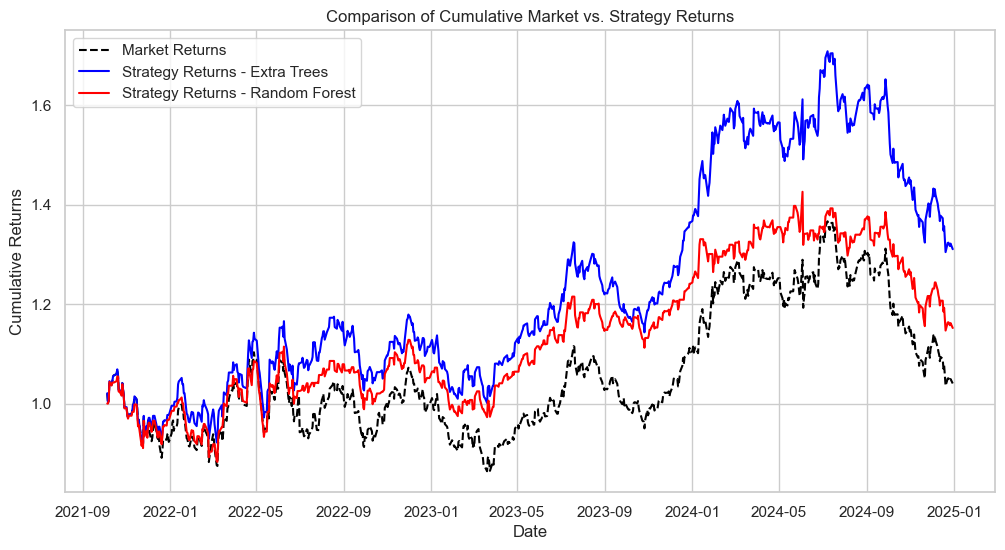

In [82]:
# Compute strategy returns
df_strategy = df.loc[X_test.index].copy()
df_strategy['Strategy_Return_ETC'] = df_strategy['Market_Return'] * etc_pred
df_strategy['Strategy_Return_RF'] = df_strategy['Market_Return'] * rf_pred

# Compute cumulative returns
df_strategy['Cumulative_Market_Return'] = (1 + df_strategy['Market_Return']).cumprod()
df_strategy['Cumulative_Strategy_Return_ETC'] = (1 + df_strategy['Strategy_Return_ETC']).cumprod()
df_strategy['Cumulative_Strategy_Return_RF'] = (1 + df_strategy['Strategy_Return_RF']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(df_strategy.index, df_strategy['Cumulative_Market_Return'], label='Market Returns', color='black',linestyle='dashed')
plt.plot(df_strategy.index, df_strategy['Cumulative_Strategy_Return_ETC'], label='Strategy Returns - Extra Trees', color='blue')
plt.plot(df_strategy.index, df_strategy['Cumulative_Strategy_Return_RF'], label='Strategy Returns - Random Forest', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Comparison of Cumulative Market vs. Strategy Returns')
plt.legend()
plt.show()


In [87]:
# Relevant columns for showcasing in the report
columns_to_show = ['Close', 'Market_Return', 'Strategy_Return_ETC', 'Strategy_Return_RF', 
                   'Cumulative_Market_Return', 'Cumulative_Strategy_Return_ETC', 'Cumulative_Strategy_Return_RF']

# Display the last 10 rows for reference
df_strategy[columns_to_show].tail(10)


Price,Close,Market_Return,Strategy_Return_ETC,Strategy_Return_RF,Cumulative_Market_Return,Cumulative_Strategy_Return_ETC,Cumulative_Strategy_Return_RF
Ticker,RELIANCE.NS,,,,,,
Date,,,,,,,
2024-12-16,1268.300049,-0.003575,-0.003575,-0.000000,1.089829,1.372588,1.206707
2024-12-17,1245.300049,-0.018135,-0.018135,-0.018135,1.070065,1.347697,1.184824
2024-12-18,1253.250000,0.006384,0.006384,0.006384,1.076896,1.356301,1.192388
2024-12-19,1230.449951,-0.018193,-0.018193,-0.018193,1.057305,1.331626,1.170695
2024-12-20,1205.300049,-0.020440,-0.020440,-0.020440,1.035694,1.304408,1.146766
2024-12-23,1222.300049,0.014104,0.014104,0.014104,1.050302,1.322806,1.162941
2024-12-24,1222.750000,0.000368,0.000368,0.000368,1.050688,1.323293,1.163369
2024-12-26,1216.550049,-0.005070,-0.005070,-0.005070,1.045361,1.316583,1.157470
